# 1) Постановка задачи

Используя схему бегущего счета и итерационные методы, решить задачу для квазилинейного уравнением переноса:

$\left\{\begin{aligned}
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x}  = 0,\ ~ 0 < x \leq 1\\
u(x,0)= \frac{4}{\pi} arctg(x-2) + 2\\
u(0,t) = (2-\frac{4}{\pi} arctg(2)) e^{-t} \\ 
\end{aligned}\\
\right. $

## Исследование характеристик
В точках пересечения проекций характеристик, решение задачи будет разрывным. Посмотрим как будут вести себя проекции характеристик в заданных областях. Уравнение характеристик будет иметь вид:

$\frac{~~dt}{1}=\frac{dx}{u} = \frac{du}{0}$

Отсюда

$\left\{\begin{aligned}
u = u(x_{0},t_{0})= const \\
t-t_{0} = \frac{1}{u} (x-x_{0}) \\ 
\end{aligned}\\
\right. $

Воспользуемся начальным и граничным условиями для получения двух семейств кривых:
    
1) $~~t_0=0: ~~~~~ t=\frac{1}{\frac{4}{\pi} arctg(x_0-2) + 2}(x-x_0)$

2) $~~x_0=0: ~~~~~ t=\frac{1}{(2 - \frac{4}{\pi} arctg(2)) e^{-t_0}} x +t_0$


Импортируем необходимые библиотеки.

In [1]:
import math 
from math import *
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

Определим функции характеристик через массивы, где итерирование будет идти по соответствующему неизвестному параметру: $x_0$ или $t_0$  . Здесь $x_0$ и $t_0$ взяты с определенными шагами c помощью np.arange.

In [2]:
def ch1(x):
    return [((1/((4/math.pi)*math.atan(x0-2)+2))*(x-x0)) 
            for x0 in np.arange(0, 1.1, .1)]

def ch2(x):
    return [(1/((2-(4/math.pi)*math.atan(2))*exp(-t0)) * (x) + t0) 
            for t0 in np.arange(0, 1.1, .1)]

 Создадим массив значений по $x$ от $0$ до $1$ с определенным шагом и соответствующие массивы для функций с итерированием уже по $x$. 

In [3]:
x_list = np.arange(0, 1.1, .1)

ch1_list = [ch1(x) for x in x_list]
ch2_list = [ch2(x) for x in x_list]

Построим соответствующие графики.

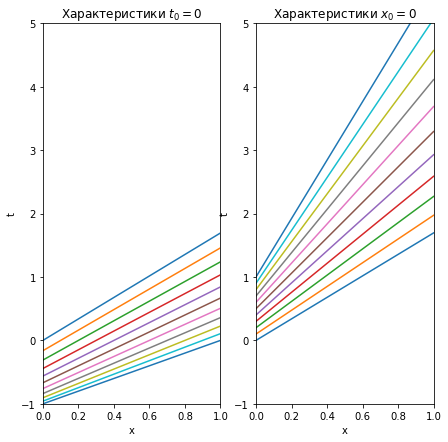

In [4]:
plt.subplots(1, 2, figsize = (7, 7))
names_list = ['$t_0 = 0$', '$x_0 = 0$']
ch_list = [ch1_list, ch2_list]
for i in (0, 1):
    plt.subplot(1, 2, i+1, title = 'Характеристики {0}'.format(names_list[i]), 
                xlabel = 'x', ylabel = 't', xlim = (0, 1), ylim = (-1, 5))
    plt.plot(x_list, ch_list[i])
plt.show()

Как видим, в заданных областях пересечений нет. Следовательно, нет так называемого опрокидывания волны, можно использовать разностные методы для решения.

# 2) Описание разностной схемы

## Сетка
Введем в области $\Omega=\{(x,t):0 < x \leq 1,~~0<t<T\} $ сетку с шагом $h_x$ по $x$ и шагом $h_t$ по $t$:
\begin{eqnarray}
\omega_{h_x, ~ h_t}=\begin{cases}
x_n=n\cdot h_x, ~~h_x=\frac{1}{N}, ~~n=\overline{0, N}\\
t_m=m\cdot h_t, ~~h_t=\frac{1}{M}, ~~m=\overline{0, M}
\end{cases}
\end{eqnarray}

На $\omega_{h_x, ~ h_t}$ будем рассматривать сеточную функцию $y^m_{n}=u(x_n,t_m)$

## Шаблон

Перепишем исходное уравнение, приведя его к дивергентному виду: 

$$\frac{\partial u}{\partial t} + \frac{\partial (u^2/2)}{\partial x} = 0 $$

Для рассматриваемой задачи будем использовать четырехточечный шаблон. Он безусловно устойчив и аппроксимирует задачу как $ O({h_x}^2 + {h_t}^2)$.
![Четырехточечный шаблон](4-dots.png "Четырехточечный шаблон")

Таким образом, разностная схема задачи имеет вид:

$$\tag{$*$}\frac{y^{m+1}_n - y^m_{n} + y^{m+1}_{n+1} - y^m_{n+1}}{2h_t} + \frac{(y^{m}_{n+1})^{2} - (y^{m}_{n})^{2} + (y^{m+1}_{n+1})^2 - (y^{m+1}_{n})^2}{2 * 2h_x}=0$$ 

Также начальное и граничное условия:

$$\left\{\begin{aligned} 
y^0_n= \frac{4}{\pi} arctg(n h_x-2) + 2 \\
y^{m}_0 = (2-\frac{4}{\pi} arctg(2))  e^{-m h_t } 
\end{aligned}\\
\right. $$


## Cхема бегущего счета
Разностное уравнение $(*)$ является нелинейным относительно искомой функции $y^{m+1}_{n+1}$ и задает значения этой функции в неявном виде. Будем решать это уравнение итерационным методом Ньютона. Имеем:

$$f(y^{m+1}_{n+1}) = \frac{y^{m+1}_n - y^m_{n} + y^{m+1}_{n+1} - y^m_{n+1}}{2h_t} + \frac{(y^{m}_{n+1})^{2} - (y^{m}_{n})^{2} + (y^{m+1}_{n+1})^2 - (y^{m+1}_{n})^2}{2 * 2h_x}=0$$

$$ f'(y^{m+1}_{n+1}) = \frac{1}{2*h_t} + \frac{y^{m+1}_{n+1}}{2*h_x} $$

$$ {y^{m+1}_{n+1}}^{(s+1)} = {y^{m+1}_{n+1}}^{(s)} - \frac{ f({y^{m+1}_{n+1}}^{(s)}) }  { f'({y^{m+1}_{n+1}}^{(s)}) } $$

До достижения заданной точности $ \epsilon $: $$ | {y^{m+1}_{n+1}}^{(s+1)} - {y^{m+1}_{n+1}}^{(s)} | \leq \epsilon $$

# 3) Реализация разностной схемы

Зададим: $\epsilon$ - точность в методе Ньютона, $N$ - количество шагов по $x$, $М$ - количество шагов по $y$, а также границы нашей сетки. 

In [5]:
epsilon = 0.0001
N = 100; M = 100
T_begin = 0.; T_end = 1.
X_begin = 0.; X_end = 1.

Соответственно, элементарные шаги.

In [6]:
h_x=(X_end - X_begin)/(N-1)
h_t=(T_end - T_begin)/(M-1)

Создадим двумерный массив размерами с нашу сетку($N{\times}M$), в ячейках которого будут храниться значения сеточной функции в узлах

In [7]:
y=np.zeros((M,N))

Начнем заполнять его начальным и граничным значениями.

In [8]:
for n in np.arange(N):
        y[0][n] = ((4. /math.pi) * math.atan(h_x * n - 2) + 2)

for m in np.arange(M):
        y[m][0] = (2 - (4./ math.pi) * math.atan(2)) * exp(-h_t * m)

In [9]:
# сама разностная схема
def f(mp1, np1): 
    n = np1-1
    m = mp1-1
    return (y[mp1][n] - y[m][n] + y[mp1][np1] - y[m][np1]) / (2. * h_t) + \
            ((y[mp1][np1] ** 2) - (y[mp1][n] ** 2) + (y[m][np1] ** 2) - (y[m][n] ** 2)) / (4. * h_x)

def f_der(mp1,np1):
    return (1/(2.*h_t) + y[mp1][np1]/(2. * h_x))

Перейдем к методу Ньютона, пробегая по всей сетке.

In [10]:
for m in np.arange(M-1):
    for n in np.arange(N-1):
        eps = epsilon + 1 # > epsilon
        while eps > epsilon:
            ep = f(m+1, n+1) / f_der(m+1, n+1)
            y[m+1][n+1] = y[m+1][n+1] - ep
            eps = abs(ep)  

# 4) График решения

<IPython.core.display.Javascript object>


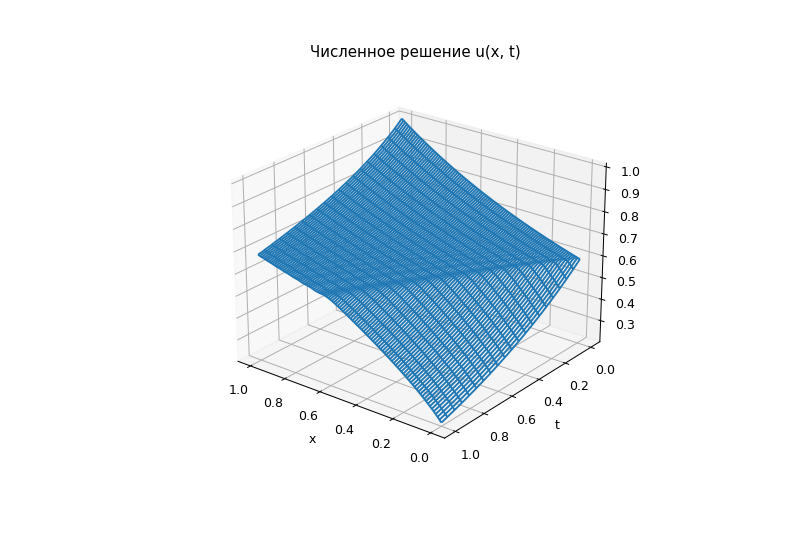

Text(0.5, 0, 't')

In [14]:
%matplotlib notebook

tm = np.linspace(T_begin,T_end, num=M)
xn = np.linspace(X_begin, X_end, num=N)

X, T = np.meshgrid(xn, tm)

fig = plt.figure(figsize = (9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(azim = 128, elev = 24)
surf = ax.plot_wireframe(X, T, y, rstride=5,cstride=1)
plt.title('Численное решение u(x, t)')
plt.xlabel('x')
plt.ylabel('t')

<IPython.core.display.Javascript object>


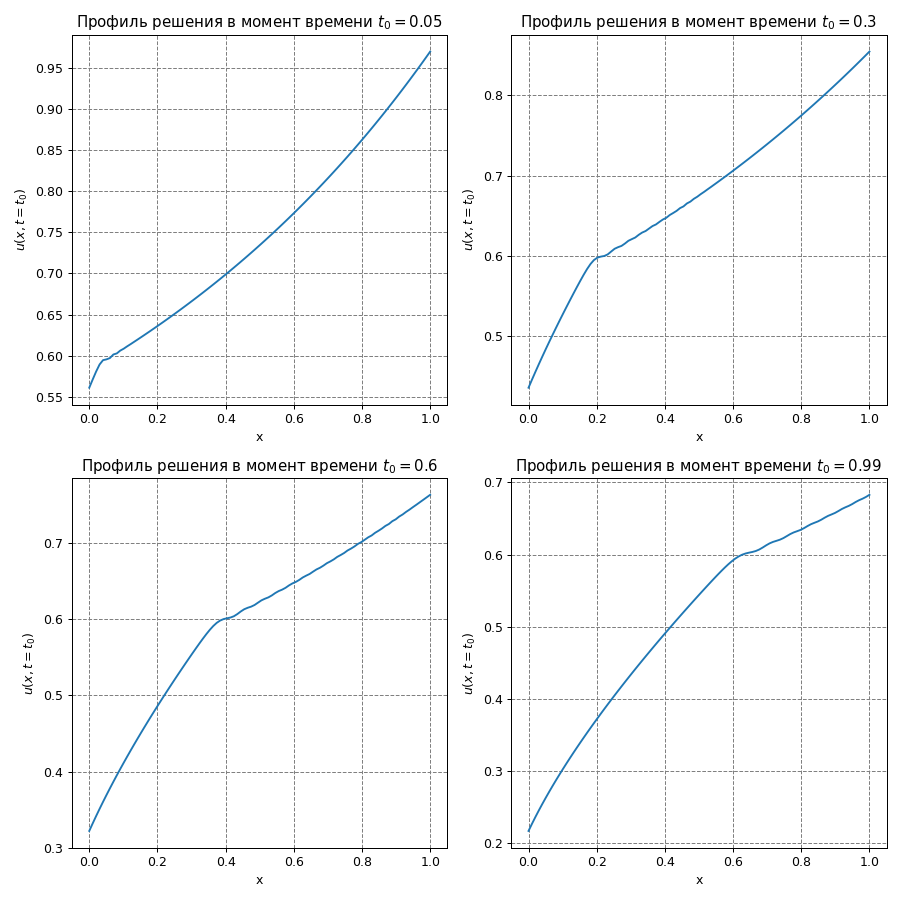

In [13]:
plt.subplots(2, 2, figsize = (10, 10))
i = 1
for t in (5, 30, 60, 99):
    plt.subplot(2, 2, i, title = 'Профиль решения в момент времени $t_0 = {0}$'.format(t/100))
    plt.plot(xn, y[t, :])
    plt.xlabel('x')
    plt.ylabel('$u(x, t = t_0)$')
    plt.grid(which='major', color = 'gray',ls='--')
    i += 1
plt.tight_layout()
